Created on Wed Aug 08 2018

@author: Neven Caplar
<br>
@contact: ncaplar@princeton.edu
<br>
@web: www.ncaplar.com

Project by Sandro Tacchella (Center for Astrophysics | Harvard & Smithsonian) and Neven Caplar (Princeton University)

Packages which you need to run the notebook that are a bit more advanced:

1. pandas
2. tqdm (not crucial and can be removed without loss of functionality, only used for monitoring calculations)
3. DELCgen (https://github.com/samconnolly/DELightcurveSimulation) - unfortunately, this requires Python2. Installation is very easy!



This cell below contains some extensions that I use that make life much easier when using jupyter notebook. These are not crucial and can be skipped. 
They can be downloaded from https://github.com/ipython-contrib/jupyter_contrib_nbextensions

In [1]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2

#import statments
import numpy as np
import pandas as pd
import io
from tqdm import tqdm
from __future__ import division

from MS_Variability import *

# this is the package that actually generates the SFR histories
from DELCgen import *

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams.update({'font.size': 24})
%config InlineBackend.rc = {}
%matplotlib inline

Welcome to MS_variability package - you have just imported tabulated auto-correlation functions.
These auto-correlation function have been computed numerically in Wolfram Mathematica (notebook also avaliable in the Github folder) for PSD=1/(1+(f/f_bend)^(slope)),where tau=1/f_bend and f is frequency.
They are tabulated as function of tau (invserse frequncy of the break in the PSD), slope (high frequency slope of the PSD) and time.
Avaliable tau (in units of Myr) are: [   10.    15.    20.    25.    30.    35.    40.    45.    50.    55.
    60.    65.    70.    75.    80.    85.    90.    95.   100.   150.
   200.   250.   300.   350.   400.   450.   500.   550.   600.   650.
   700.   750.   800.   850.   900.   950.  1000.]
Avaliable slopes are: [ 0.   1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4
  2.5  2.6  2.7  2.8  2.9]
Longest avaliable time is [Myr]: 1000.0


# Some theoretical plots to get started

## Looking at the ACF

<font size="4"> Autocorellation function (ACF) is deeply connected with the power spectrum density (PSD), which determines stochastic behaviour of galaxy. In essence, when we are considering width of the Main Sequence (MS), we are measuring ACF of the stochastic process that is convolved with a non-trivial response function of each measurement indicator. The figure below shows how ACFs depend on the slope, $\alpha$, and timescale of the break,$\tau_{break}$. You can get them using the function <font color=red>get_ACF($\tau_{break}$, slope)</font>. This will return 2d array, giving [time,ACF as a function of time].

For slope 2 (damped random walk) we know the exact result: $ACF(t)=\exp(-t/(\tau_{break}2\pi))$.
We can verify below, in the right hand side, that this is true - dashed line is set at $\exp(-1)$ to help guide the eye. On the left hand side, One can also notice small jumps in the ACF, which are due to numerical instabilities in the numerical integration for shallow slopes.
<br>
<br>
Colors are from colorbrewer2.org.

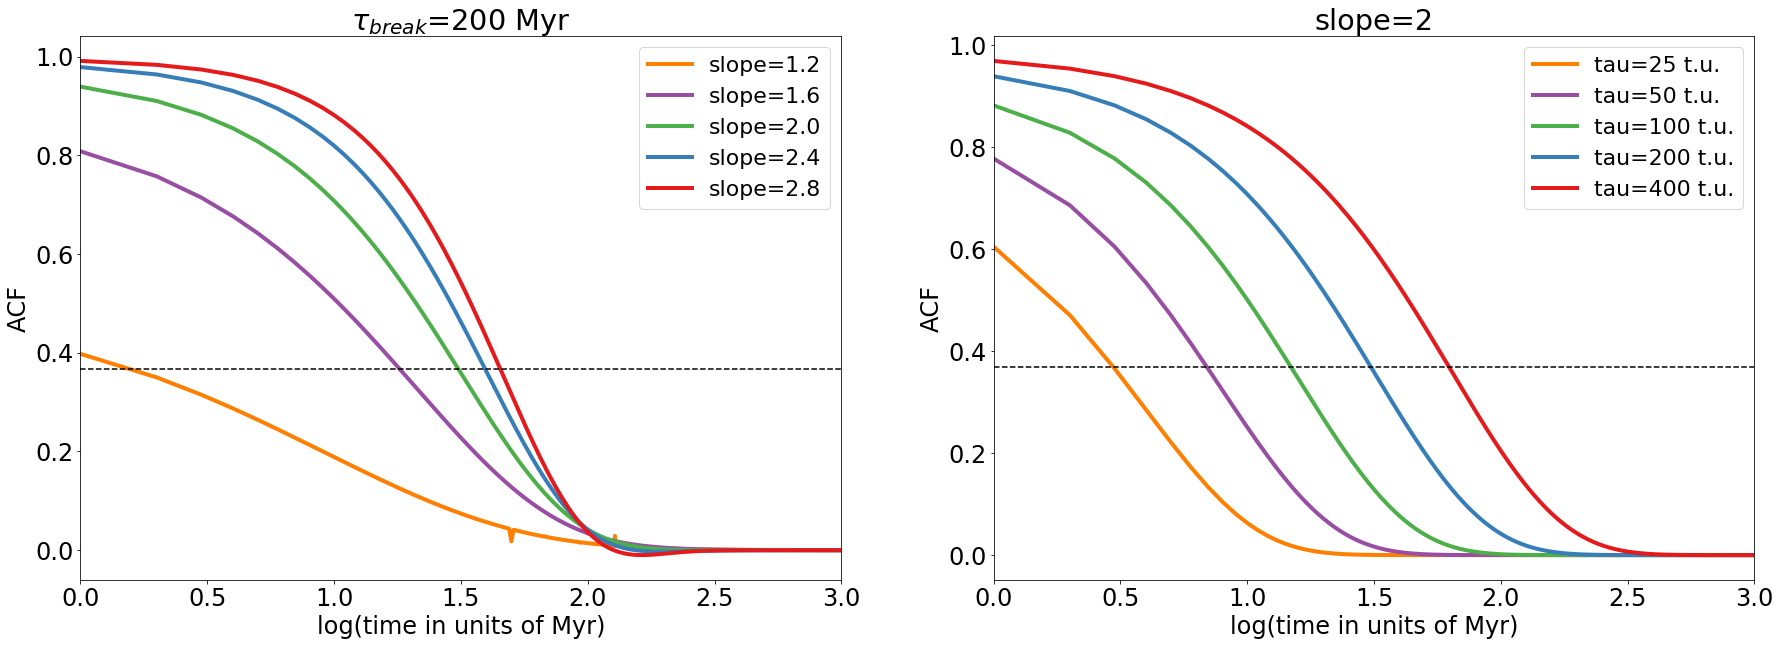

In [4]:
# set parameters of the PSD
plot_slope=2
plot_tau=200

plt.figure(figsize=(30,10))
plt.subplot(121)

# generate examples, keeping tau fixed and changing slope
ACF_Example1=get_ACF(plot_tau,1.2)
ACF_Example2=get_ACF(plot_tau,1.6)
ACF_Example3=get_ACF(plot_tau,2)
ACF_Example4=get_ACF(plot_tau,2.4)
ACF_Example5=get_ACF(plot_tau,2.8)

# plot them
plt.plot(np.log10(ACF_Example1[:,0]),ACF_Example1[:,1],color='#ff7f00',label='slope=1.2',lw=4,linestyle='-')
plt.plot(np.log10(ACF_Example2[:,0]),ACF_Example2[:,1],color='#984ea3',label='slope=1.6',lw=4)
plt.plot(np.log10(ACF_Example3[:,0]),ACF_Example3[:,1],color='#4daf4a',label='slope=2.0',lw=4)
plt.plot(np.log10(ACF_Example4[:,0]),ACF_Example4[:,1],color='#377eb8',label='slope=2.4',lw=4)
plt.plot(np.log10(ACF_Example5[:,0]),ACF_Example5[:,1],color='#e41a1c',label='slope=2.8',lw=4)
plt.plot(np.array(range(10)),np.full((10),1/np.exp(1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of Myr)')
plt.ylabel('ACF')
plt.title('$\\tau_{break}$='+str(plot_tau)+' Myr')
plt.legend(fontsize=22)


plt.subplot(122)

# generate examples, keeping slope fixed and changing tau
ACF_Example1=get_ACF(25,plot_slope)
ACF_Example2=get_ACF(50,plot_slope)
ACF_Example3=get_ACF(100,plot_slope)
ACF_Example4=get_ACF(200,plot_slope)
ACF_Example5=get_ACF(400,plot_slope)

# plot them
plt.plot(np.log10(ACF_Example1[:,0]),ACF_Example1[:,1],color='#ff7f00',label='tau=25 t.u.',lw=4,linestyle='-')
plt.plot(np.log10(ACF_Example2[:,0]),ACF_Example2[:,1],color='#984ea3',label='tau=50 t.u.',lw=4)
plt.plot(np.log10(ACF_Example3[:,0]),ACF_Example3[:,1],color='#4daf4a',label='tau=100 t.u.',lw=4)
plt.plot(np.log10(ACF_Example4[:,0]),ACF_Example4[:,1],color='#377eb8',label='tau=200 t.u.',lw=4)
plt.plot(np.log10(ACF_Example5[:,0]),ACF_Example5[:,1],color='#e41a1c',label='tau=400 t.u.',lw=4)
plt.plot(np.array(range(10)),np.full((10),np.exp(-1)),color='black',linestyle='--')

plt.xlim(0,3)
plt.xlabel('log(time in units of Myr)')
plt.ylabel('ACF')
plt.title('slope='+str(plot_slope))
plt.legend(fontsize=22)

## Scatter of the main sequence in a toy model (Section 3 and left panel of Figure 5.)

<font size="4"> In Section 3 we have developed a toy model, where considered a simplified case in which measurement with a given indicator is equivalent to averaging of the previous star-formation. Given the scatter of the main sequence measured at a timescale of 1 Myr, scatter of the main sequence measured by a longer time indicator (e.g., H$\alpha$, UV etc...) will be very well approximated (Equation (16) from the manuscript):


$\sigma_{ind,MS}=\frac{\sigma_{MS}}{\sqrt{N}} \left(1 + 2 \sum^{N}_{j=1} \left(1-\frac{j}{N} \right)ACF(j)  \right)^{1/2} $ 

where N is numer of times than the longer time indicator is larger (longer) than the timescale of 1 Myr. (relation derived in the paper, but also see e.g., Ivezic, Connolly, VanderPlas and Gray, 2014 Equation (10.93); or Priestley 1981, Equation (5.3.5))

<font size="4"> Below we show an example, illustrating how the scatter depends on the parameters of the PSD (slope $\alpha$ and the timescale of the break, $\tau_{break}$). We use the function <font color=red>get_scatter_MS(timescale of the break, slope)</font>. We expand on the usage of this function further below. The information presented is very similar to the information on the left hand side of Figure 5, where we have presented the same information derived from numerical simulations (to avoid problems due to the fact that the equation above is only an approximation). 


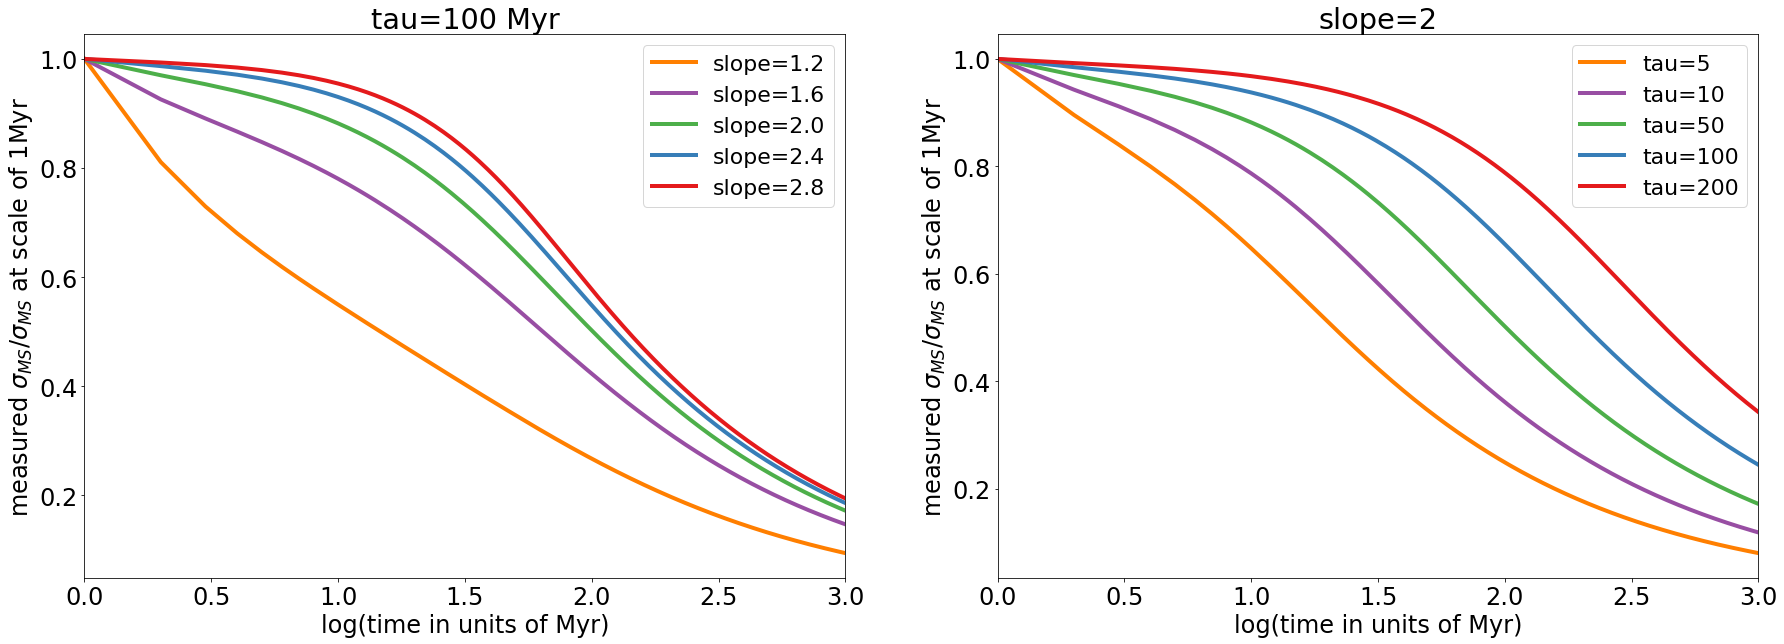

In [5]:
# parameters of PSPD
plot_slope=2
plot_tau=100

plt.figure(figsize=(30,10))

plt.subplot(121)

# generate examples, keeping tau fixed and changing slope
Scatter_Example1=get_scatter_MS(plot_tau,1.2)
Scatter_Example2=get_scatter_MS(plot_tau,1.6)
Scatter_Example3=get_scatter_MS(plot_tau,2)
Scatter_Example4=get_scatter_MS(plot_tau,2.4)
Scatter_Example5=get_scatter_MS(plot_tau,2.8)

# plot them
plt.plot(np.log10(Scatter_Example1[:,0]),Scatter_Example1[:,1],color='#ff7f00',label='slope=1.2',lw=4,linestyle='-')
plt.plot(np.log10(Scatter_Example2[:,0]),Scatter_Example2[:,1],color='#984ea3',label='slope=1.6',lw=4)
plt.plot(np.log10(Scatter_Example3[:,0]),Scatter_Example3[:,1],color='#4daf4a',label='slope=2.0',lw=4)
plt.plot(np.log10(Scatter_Example4[:,0]),Scatter_Example4[:,1],color='#377eb8',label='slope=2.4',lw=4)
plt.plot(np.log10(Scatter_Example5[:,0]),Scatter_Example5[:,1],color='#e41a1c',label='slope=2.8',lw=4)

plt.xlim(0,3)
plt.xlabel('log(time in units of Myr)')
plt.ylabel('measured $\sigma_{MS}$/$\sigma_{MS}$ at scale of 1Myr')
plt.title('tau='+str(plot_tau)+' Myr')
plt.legend(fontsize=22)

plt.subplot(122)

# generate examples, keeping slope fixed and changing tau
Scatter_Example1=get_scatter_MS(25,plot_slope)
Scatter_Example2=get_scatter_MS(50,plot_slope)
Scatter_Example3=get_scatter_MS(100,plot_slope)
Scatter_Example4=get_scatter_MS(200,plot_slope)
Scatter_Example5=get_scatter_MS(400,plot_slope)

# plot them
plt.plot(np.log10(Scatter_Example1[:,0]),Scatter_Example1[:,1],color='#ff7f00',label='tau=5',lw=4,linestyle='-')
plt.plot(np.log10(Scatter_Example2[:,0]),Scatter_Example2[:,1],color='#984ea3',label='tau=10',lw=4)
plt.plot(np.log10(Scatter_Example3[:,0]),Scatter_Example3[:,1],color='#4daf4a',label='tau=50',lw=4)
plt.plot(np.log10(Scatter_Example4[:,0]),Scatter_Example4[:,1],color='#377eb8',label='tau=100',lw=4)
plt.plot(np.log10(Scatter_Example5[:,0]),Scatter_Example5[:,1],color='#e41a1c',label='tau=200',lw=4)

plt.xlim(0,3)
plt.xlabel('log(time in units of Myr)')
plt.ylabel('measured $\sigma_{MS}$/$\sigma_{MS}$ at scale of 1Myr')
plt.title('slope='+str(plot_slope))
plt.legend(fontsize=22)

# Figure 6 - Example with simulated data, convolved with step functions

<font size="4"> Below we show few examples with generated SFR history curves and show that our theoretical predictions match what is seen in generated data.  We generate 3 examples with different timescales of the break in PSD, corresponding to the data seen in Figure 6 in the manuscript.
<br>
<br>
We use functions <font color=red>get_mean_relation($\tau_{break}$)</font> and <font color=red>get_scatter_MS($\tau_{break}$,slope)</font>. <font color=red>get_mean_relation($\tau_{break}$)</font> is only defined for damped random walk (slope=2) and gives back and array of values with [$\Delta_{MS}$ (intrinsic),$\Delta_{MS}$ (measured)], assuming response function is a step function with a duration of 100 Myr and assuming intrinsic width of Main Sequence = 0.4 dex. For different response times and widths, this can be supplied as a third and forth argument respectively. For example  <font color=red>get_mean_relation(20,90,0.3)</font> gives array describing offset for $\tau_{break}$=20 Myr, response time with duration of 100 Myr, and intrinsic width of Main Sequence = 0.3 dex.
<br>
<br>
 <font color=red>get_scatter_MS($\tau_{break}$,slope)</font> gives back a array, denoting how much tighter the measured Main Sequence is compared to the intrinsic width, as a function of measuring time. For example  <font color=red>get_scatter_MS(100,2)[50]</font> gives the predicted scatter of the process with $\tau_{break}$=50 Myr, slope=2 and measurement is averaged of 51 Myr (50+1).It also has few options, and a possibility to accept more complicated response functions, if needed (see definition of the function in the module).

</font>

In [6]:
# amplitude
A=1
#slope on the short time scales
a_low=2
#slope on the long time scales - by definition in our work this is set at 0
a_high=0
# intercept/offset: adds constant to the final output; not used it this work
c=0

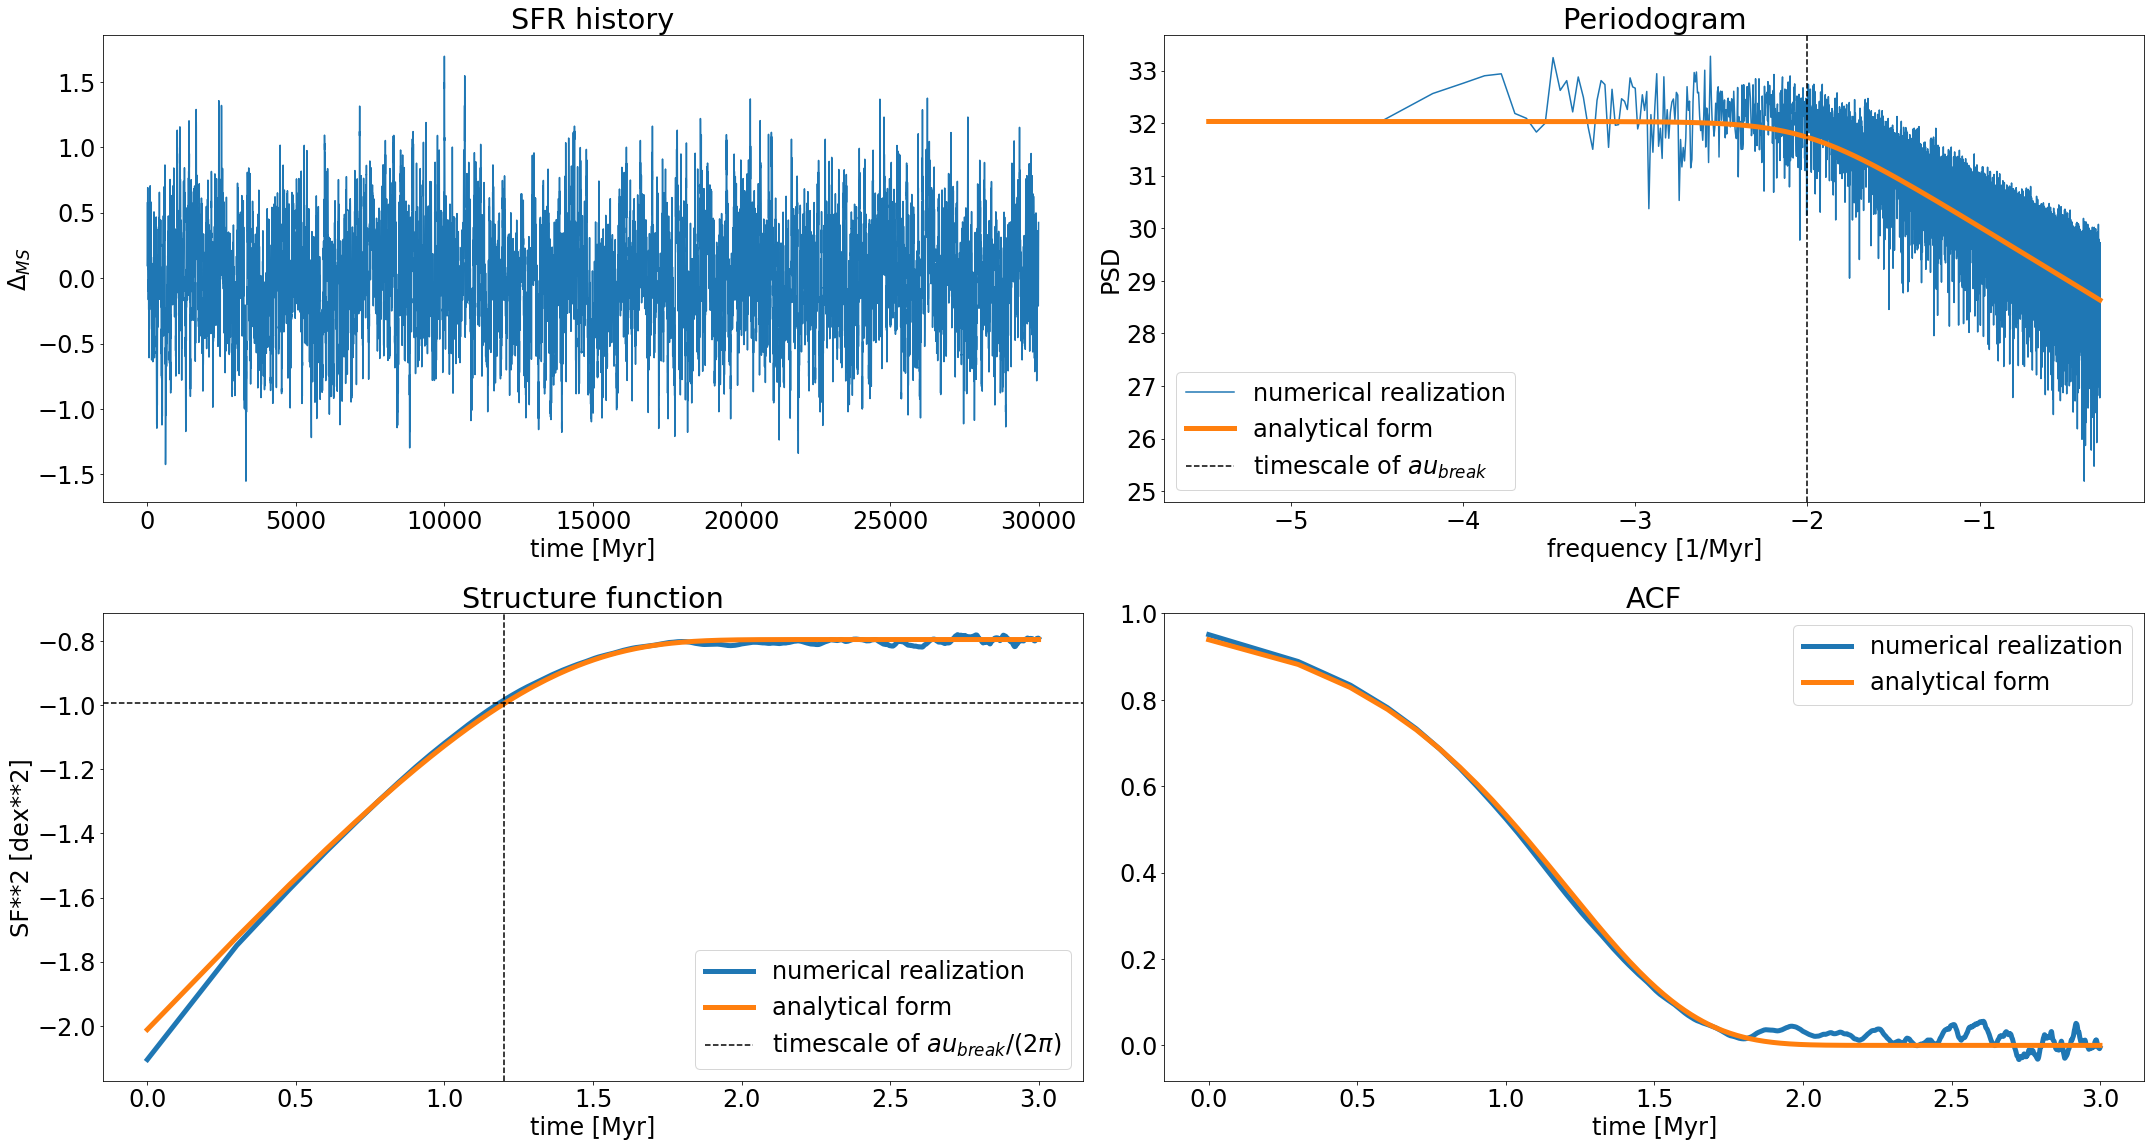

In [7]:
# set frequency of the break
v_bend_Example1=1.0/(20)
# simulate the SFR history - we simulate very long history to not be senitive to potential aliasing (basically edge effects)
# and to fully probe stochastic process
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend_Example1,a_low,a_high,0),RedNoiseL=1,aliasTbin=1,tbin = 1,length=30000,randomSeed=1234)
#Set scatter of the Main Sequence at 0.4 dex in this example
delc1=delc
delc_flux_Example1=0.4*delc.flux

# repeat the same procedure for a second example with different tau_break
v_bend_Example2=1.0/(100)
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend_Example2,a_low,a_high,0),RedNoiseL=1,aliasTbin=1,tbin = 1,length=30000,randomSeed=1234)
delc2=delc
delc_flux_Example2=0.4*delc.flux

# repeat the same procedure for a third example with different tau_break
v_bend_Example3=1.0/(500)
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend_Example3,a_low,a_high,0),RedNoiseL=1,aliasTbin=1,tbin = 1,length=300000,randomSeed=1234)
delc3=delc
delc_flux_Example3=0.4*delc.flux

#############################################
# Calculate explicit PSDs, that we will show on the final plot
frequency = np.arange(1.0, (300000)/2 +1)/ (300000)
explicit1=BendingPL(frequency,A,v_bend_Example1,a_low,a_high,0)
explicit2=BendingPL(frequency,A,v_bend_Example2,a_low,a_high,0)
explicit3=BendingPL(frequency,A,v_bend_Example3,a_low,a_high,0)

#############################################
# Calculate structure functions of the processes - We did not explicity used structure functions in the paper, but they are a quantity
#describing evolution of variance in time domain and deeply connected with ACF and PSD
SFSquared2=[]
for i in range(1,1000):
    SFSquared2.append([i,np.var(delc_flux_Example2[1:-i]-delc_flux_Example2[i+1:])/2])   
SFSquared2=np.array(SFSquared2)
SFSquared3=[]
for i in range(1,1000):
    SFSquared3.append([i,np.var(delc_flux_Example3[1:-i]-delc_flux_Example3[i+1:])/2])   
SFSquared3=np.array(SFSquared3)

#############################################
# Calculate auto-correlation functions of the processes - using Equation (1) from the manuscript
ACF_estimated2=[]
for i in range(1,1000):
    ACF_estimated2.append([i,np.mean(delc_flux_Example2[1:-i]*delc_flux_Example2[i+1:])/(0.4**2)])   
ACF_estimated2=np.array(ACF_estimated2)

ACF_estimated3=[]
for i in range(1,1000):
    ACF_estimated3.append([i,np.mean(delc_flux_Example3[1:-i]*delc_flux_Example3[i+1:])/(0.4**2)])   
ACF_estimated3=np.array(ACF_estimated3)
#############################################
# Plot showing created movement around Main Sequence, the periodogram, the structure function and the ACF
# shown for the example with tau_{break} = 100, i.e., example 2
plt.figure(figsize=(30,16))
plt.subplot(221)
plt.plot(delc_flux_Example2)
plt.title('SFR history')
plt.xlabel('time [Myr]')
plt.ylabel('$\\Delta_{MS}$ ')

plt.subplot(222)
plt.plot(np.log10(delc2.periodogram[0]),np.log10(delc2.periodogram[1]),label='numerical realization')
plt.plot(np.log10(frequency),np.log10(explicit2)+np.log10(delc2.periodogram[1])[0]-np.log10(explicit2)[0],lw=5,label='analytical form')
plt.axvline(np.log10(v_bend_Example2),ls='--',color='black',label='timescale of $\tau_{break}$')
plt.title('Periodogram')
plt.xlabel('frequency [1/Myr]')
plt.ylabel('PSD')
plt.legend()

plt.subplot(223)
plt.plot(np.log10(SFSquared2[:,0]),np.log10(SFSquared2[:,1]),lw=5,label='numerical realization')
plt.plot(np.log10(range(1,1000)),np.log10(0.4**2*(1-np.exp(-np.array(range(1,1000))/(1/(v_bend_Example2*2*np.pi))))),lw=5,label='analytical form')
plt.axhline(np.log10(0.4**2*(1-np.exp(-1))),ls='--',color='black')
plt.axvline(np.log10((1/v_bend_Example2)/(2*np.pi)),ls='--',color='black',label='timescale of $\tau_{break}/(2 \pi)$')
plt.title('Structure function')
plt.xlabel('time [Myr]')
plt.ylabel('SF**2 [dex**2]')
plt.legend()

plt.subplot(224)
plt.plot(np.log10(ACF_estimated2[:,0]),ACF_estimated2[:,1],lw=5,label='numerical realization')
plt.plot(np.log10(range(1,1000)),np.exp(-np.array(range(1,1000))/(1/(v_bend_Example2*2*np.pi))),lw=5,label='analytical form')
plt.title('ACF')
plt.xlabel('time [Myr]')
plt.ylabel('')
plt.legend()

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

In [8]:
# We denote with Tmax the timescale over which SFR is measured 
Tmax=100

# generate observed 'data' from generated SFR histories
res_Example1=[]
res_Example2=[]
res_Example3=[]
random_start_positions=np.unique(np.random.randint(0,len(delc_flux_Example1)-Tmax-1,4000))

# for each example take 1. one SFR history position (SFR_Halpha = SFR_real) and 2. 100 adjecent points and average them (this mimics measurement, and creates SFR_mes)

for i in range(len(random_start_positions)):
    res_Example1.append([delc_flux_Example1[random_start_positions[i]+Tmax],np.log10(np.mean(np.power(10,delc_flux_Example1[random_start_positions[i]+1:random_start_positions[i]+Tmax+1])))])
    res_Example2.append([delc_flux_Example2[random_start_positions[i]+Tmax],np.log10(np.mean(np.power(10,delc_flux_Example2[random_start_positions[i]+1:random_start_positions[i]+Tmax+1])))])
    res_Example3.append([delc_flux_Example3[random_start_positions[i]+Tmax],np.log10(np.mean(np.power(10,delc_flux_Example3[random_start_positions[i]+1:random_start_positions[i]+Tmax+1])))])
    
res_Example1=np.array(res_Example1)    
res_Example2=np.array(res_Example2)    
res_Example3=np.array(res_Example3)  

In [9]:
# Estimate mean relation from the data between 'real SFR' and 'SFR measured'
# We select SFR measurment in narrow bins and find mean measured SFR
# Some errors here are normal, as sometimes we try to estimate mean of an empty bin
SFR_SFR_Example1=[]
SFR_SFR_Example2=[]
SFR_SFR_Example3=[]
for i in np.arange(-1.5,1.5,0.05):
    res_Example1_bin=res_Example1[np.all([res_Example1[:,0]<i+0.05, res_Example1[:,0]>i],axis=0)]
    SFR_SFR_Example1.append([np.log10(np.mean(np.power(10,res_Example1_bin[:,0]))),np.log10(np.mean(np.power(10,res_Example1_bin[:,1]))),np.std(res_Example1_bin[:,1])])
    res_Example2_bin=res_Example2[np.all([res_Example2[:,0]<i+0.05, res_Example2[:,0]>i],axis=0)]
    SFR_SFR_Example2.append([np.log10(np.mean(np.power(10,res_Example2_bin[:,0]))),np.log10(np.mean(np.power(10,res_Example2_bin[:,1]))),np.std(res_Example2_bin[:,1])])
    res_Example3_bin=res_Example3[np.all([res_Example3[:,0]<i+0.01, res_Example3[:,0]>i],axis=0)]
    SFR_SFR_Example3.append([np.log10(np.mean(np.power(10,res_Example3_bin[:,0]))),np.log10(np.mean(np.power(10,res_Example3_bin[:,1]))),np.std(res_Example3_bin[:,1])])
    
SFR_SFR_Example1=np.array(SFR_SFR_Example1)
SFR_SFR_Example2=np.array(SFR_SFR_Example2)
SFR_SFR_Example3=np.array(SFR_SFR_Example3)


/home/caplarn/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/caplarn/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/caplarn/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/caplarn/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/caplarn/anaconda2/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [10]:
# Theoretical mean relation between 'real SFR' and 'SFR measured'
# This invokes Equation (14) from the paper, using ACF presented at the start
# usage get_mean_relation(time scale of the break, length of the averaging, \sigma_{MS})

tau_Example1=(1/v_bend_Example1)
SFR_UV_Theoretical_Example1=get_mean_relation(tau_Example1,Tmax,0.4)

tau_Example2=(1/v_bend_Example2)
SFR_UV_Theoretical_Example2=get_mean_relation(tau_Example2,Tmax,0.4)

tau_Example3=(1/v_bend_Example3)
SFR_UV_Theoretical_Example3=get_mean_relation(tau_Example3,Tmax,0.4)

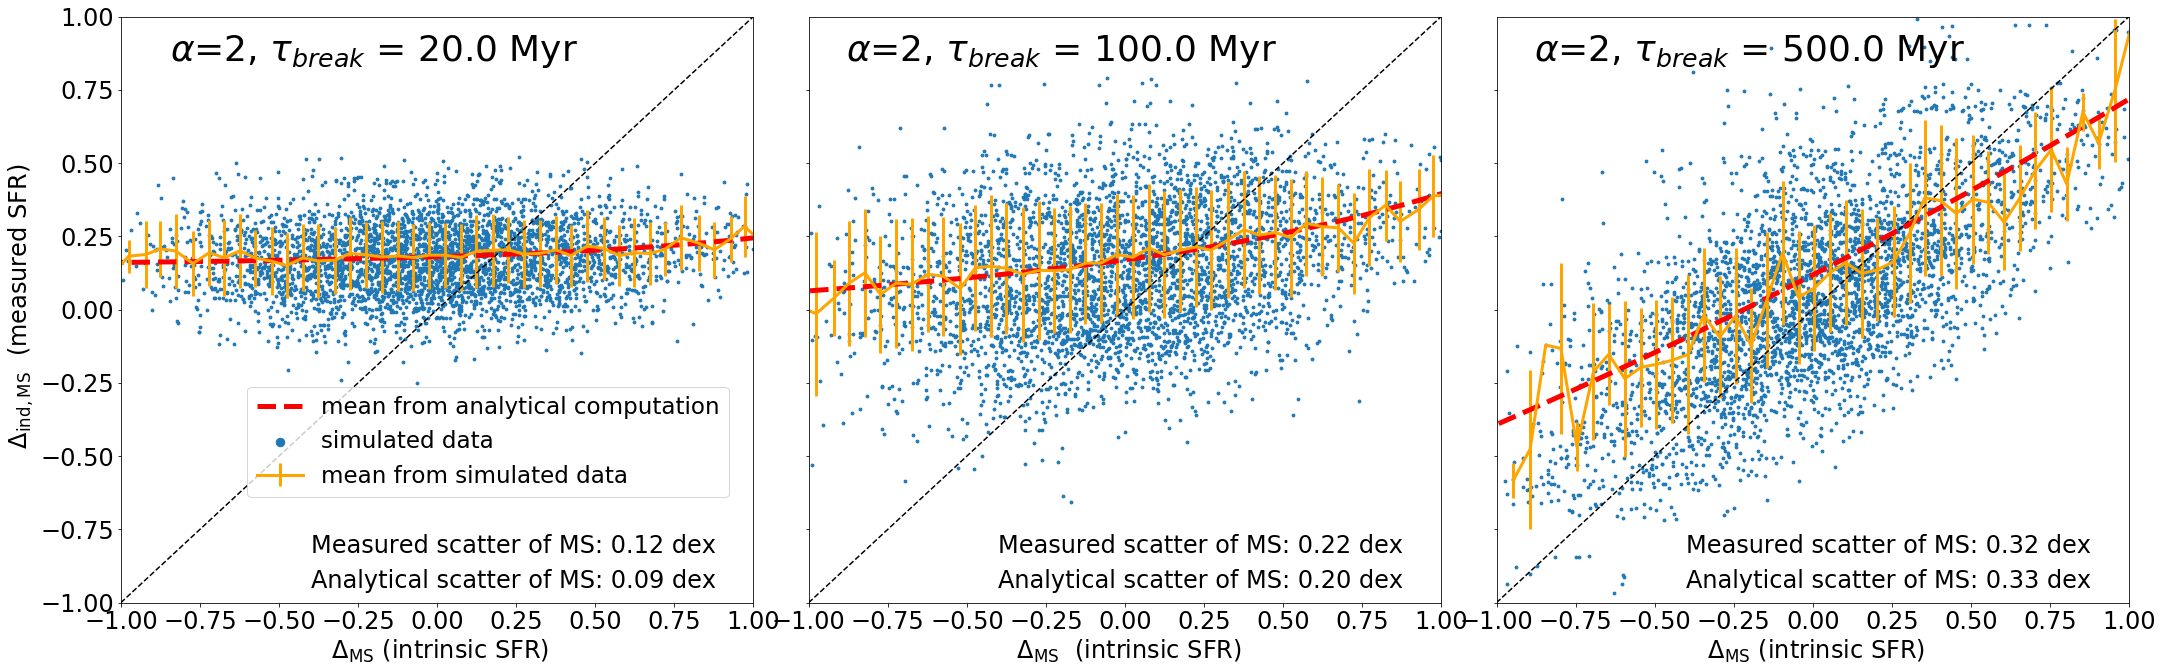

In [11]:
# plot the final result, together with all of the explanations

plt.figure(figsize=(30,9.4))

plt.subplot(1,3,1)
plt.scatter(res_Example1[:,0],res_Example1[:,1],label='simulated data',s=8)
plt.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')
plt.xlabel(' $\mathregular{\Delta_{MS}} $ (intrinsic SFR)')
plt.ylabel(' $\mathregular{\Delta_{ind,MS}}$  (measured SFR)')
plt.errorbar(SFR_SFR_Example1[:,0],SFR_SFR_Example1[:,1],yerr=SFR_SFR_Example1[:,2],color='orange',lw=3,label='mean from simulated data')
plt.plot(SFR_UV_Theoretical_Example1[:,0],SFR_UV_Theoretical_Example1[:,1],color='red',ls='--',lw=5,label='mean from analytical computation')
plt.legend(loc=(0.20,0.18),markerscale=3,fontsize=23)
plt.text(-0.2,.85,"$\\alpha$="+str(a_low)+", $\\tau_{break}$ = "+str(tau_Example1)+" Myr",
        horizontalalignment='center',fontsize=36)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.text(-0.4, -0.83,"Measured scatter of MS: "+"%.2f" % round(np.std(res_Example1[:,1]),2)+" dex",{'color': 'black', 'fontsize': 24})
plt.text(-0.4, -0.95,"Analytical scatter of MS: "+"%.2f" % round(get_scatter_MS(tau_Example1,a_low)[Tmax-1][1]*0.4,2)+" dex",{'color': 'black', 'fontsize': 24})

plt.subplot(1,3,2)
plt.scatter(res_Example2[:,0],res_Example2[:,1],label='simulated data',s=8)
plt.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')
plt.xlabel(' $\mathregular{\Delta_{MS}}$  (intrinsic SFR)')
plt.errorbar(SFR_SFR_Example2[:,0],SFR_SFR_Example2[:,1],yerr=SFR_SFR_Example2[:,2],color='orange',lw=3)
plt.plot(SFR_UV_Theoretical_Example2[:,0],SFR_UV_Theoretical_Example2[:,1],color='red',ls='--',lw=5)
plt.text(-0.2,.85,"$\\alpha$="+str(a_low)+", $\\tau_{break}$ = "+str(tau_Example2)+" Myr",
        horizontalalignment='center',fontsize=36)
plt.yticks(np.arange(-1, 1, step=0.25),[])
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.text(-0.4, -0.83,"Measured scatter of MS: "+"%.2f" % round(np.std(res_Example2[:,1]),2)+" dex",{'color': 'black', 'fontsize': 24})
plt.text(-0.4, -0.95,"Analytical scatter of MS: "+"%.2f" % round(get_scatter_MS(tau_Example2,a_low)[Tmax-1][1]*0.4,2)+" dex",{'color': 'black', 'fontsize': 24})


plt.subplot(1,3,3)
plt.scatter(res_Example3[:,0],res_Example3[:,1],s=8)
plt.plot(np.arange(-3,3,0.01),np.arange(-3,3,0.01),color='black',ls='--')
plt.xlabel(' $\mathregular{\Delta_{MS}}$ (intrinsic SFR)')
plt.errorbar(SFR_SFR_Example3[:,0],SFR_SFR_Example3[:,1],yerr=SFR_SFR_Example3[:,2],color='orange',lw=3)
plt.plot(SFR_UV_Theoretical_Example3[:,0],SFR_UV_Theoretical_Example3[:,1],color='red',ls='--',lw=5)
plt.text(-0.2,.85,"$\\alpha$="+str(a_low)+", $\\tau_{break}$ = "+str(tau_Example3)+" Myr",
        horizontalalignment='center',fontsize=36)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.yticks(np.arange(-1, 1, step=0.25),[])

plt.text(-0.4, -0.83,"Measured scatter of MS: "+"%.2f" % round(np.std(res_Example3[:,1]),2)+" dex",{'color': 'black', 'fontsize': 24})
plt.text(-0.4, -0.95,"Analytical scatter of MS: "+"%.2f" % round(get_scatter_MS(tau_Example3,a_low)[Tmax-1][1]*0.4,2)+" dex",{'color': 'black', 'fontsize': 24})


plt.tight_layout(pad=0.4, w_pad=0.3, h_pad=1.0)

#plt.savefig('/Users/nevencaplar/Documents/Variability/MainSequence/Paper/Figures/' + 'distribution_single.pdf', bbox_inches='tight')
plt.show()


# Figure 7 - Determining slope and time-scale from the data (response given with step function )

## Generating some data with known parameters

<font size="4">In this section we want to see how well we can recover the result from the data. In this example we assume that response functions of our SFR indicators are step functions, i.e., actual SFR influences SFR measurment equivalently until some time, Tmax, after which the response function drops to zero. </font>

<font size="4"> Below we generate some data with known decorellation time (400 Myr) and slope (2) to see how well we can recover the results. This uses the same code as in the section above to generate the data. We assume that we measured data with 3 indicators and that: 1. the total response time for the shortest indicator (called short indicator below) is 1 Myr, i.e., that measurment in short indicator is identical to actual SFR, 2. and the total response time for the longer indicator (called medium indicator below) is 10 Myr and 3. the total response time for the longest indicator (called long indicator) is 100 Myr. 
<br>
<br>
After we have generated the data, we estimate the scatter of the main sequence in Halpha, UV and u band, find the ratio of the measurements and the associated uncertainty. 
</font>

In [12]:
# amplitude
A=1
#slope on the short time scales
a_low=2.0
#slope on the long time scales
a_high=0
# time-scale of the break in the PSD
t_bend=400

#create actual SFR
v_bend_Example=1.0/(t_bend)
delc =Simulate_TK_Lightcurve(BendingPL, (A,v_bend_Example,a_low,a_high,0),RedNoiseL=1,aliasTbin=1,tbin = 1,length=30000,randomSeed=1234)
delc_flux_Example=0.4*delc.flux

#generate observed SFR in 'short indicator' (in this case it is the same as the actual SFR)
T1=1
convolving_array1=np.ones(T1)/T1
delc_flux_Example_convolved_decay_time1=np.log10(np.convolve(np.power(10,delc_flux_Example),convolving_array1,'full'))[5000:len(delc_flux_Example)]

#generate observed SFR in 'medium indicator'
T2=10
convolving_array2=np.ones(T2)/T2
delc_flux_Example_convolved_decay_time2=np.log10(np.convolve(np.power(10,delc_flux_Example),convolving_array2,'full'))[5000:len(delc_flux_Example)]

#generate observed SFR in 'long indicator'
T3=100
convolving_array3=np.ones(T3)/T3
delc_flux_Example_convolved_decay_time3=np.log10(np.convolve(np.power(10,delc_flux_Example),convolving_array3,'full'))[5000:len(delc_flux_Example)]


In [13]:
# put some seed for reproducibility 
np.random.seed(60)

# sample from each history and estimate scatter of the Main Sequence measred in each indicator
sample=[]
random_start_positions=np.random.randint(0,len(delc_flux_Example_convolved_decay_time2),10000)
for i in range(len(random_start_positions)):
    sample.append([delc_flux_Example_convolved_decay_time1[random_start_positions[i]],delc_flux_Example_convolved_decay_time2[random_start_positions[i]],delc_flux_Example_convolved_decay_time3[random_start_positions[i]]])
sample=np.array(sample)    

print("sigma_MS ('SFR_Halpha'): "+str(np.std(sample[:,0])))
print("sigma_MS ('SFR_UV'): "+str(np.std(sample[:,1])))
print("sigma_MS ('SFR_u'): "+str(np.std(sample[:,2])))


# Here we use bootstraping to estimate uncertainty for the ratio of measurments
# We want to use ratio to reduce dependency on the intrinsic with of the Main Sequence
# Of course, in this idealized case the uncertainty depends only on the number of galaxies that we have simulated 

# UV - Halpha (which we call case 2_1)
res=[]
for i in range(100):
    res.append(np.std(bootstrap_resample(sample[:,1]))/np.std(bootstrap_resample(sample[:,0])))

Measurment_Of_Scatter_Ratio_2_1=np.mean(res)
err_Measurment_Of_Scatter_Ratio_2_1=np.std(res)
print("Ratio of sigma_MS (SFR_medium)/sigma_MS (SFR_short): "+str(np.mean(res))+"+-"+str(np.std(res)))  

# u - Halpha (which we call case 3_1)
res=[]
for i in range(100):
    res.append(np.std(bootstrap_resample(sample[:,2]))/np.std(bootstrap_resample(sample[:,0])))

Measurment_Of_Scatter_Ratio_3_1=np.mean(res)
err_Measurment_Of_Scatter_Ratio_3_1=np.std(res)
print("Ratio of sigma_MS (SFR_long)/sigma_MS (SFR_short): "+str(np.mean(res))+"+-"+str(np.std(res)))  

# u - UV  (which we call case 3_2)
res=[]
for i in range(100):
    res.append(np.std(bootstrap_resample(sample[:,2]))/np.std(bootstrap_resample(sample[:,1])))

Measurment_Of_Scatter_Ratio_3_2=np.mean(res)
err_Measurment_Of_Scatter_Ratio_3_2=np.std(res)
print("Ratio of sigma_MS (SFR_long)/sigma_MS (SFR_medium): "+str(np.mean(res))+"+-"+str(np.std(res)))  

sigma_MS ('SFR_Halpha'): 0.401623727506
sigma_MS ('SFR_UV'): 0.391264364143
sigma_MS ('SFR_u'): 0.324485748475
Ratio of sigma_MS (SFR_medium)/sigma_MS (SFR_short): 0.97397653391+-0.00805209015338
Ratio of sigma_MS (SFR_long)/sigma_MS (SFR_short): 0.806882456407+-0.00701360356522
Ratio of sigma_MS (SFR_long)/sigma_MS (SFR_medium): 0.828538349894+-0.00687005182804


## Estimating parameters of the stochastic process from the simulated data (using scatter) 

<font size="4"> MS width supplied in the first step of the notebook have relatively coarse resolution, which is due to the fact that they are span 3-dimensional space (slope, time of decorellation, duration of step function of each indicator).  We 'know' what the durations of our indicators is, so we first create finer 2D grid of slopes and decorellation times, at a given duration a longer indicator(in this example, medium and long indicator are 10 and 100 times longer than the shortest indicator). We do this by interpolating. Note that increase of the resolution  is only done so that our results would look smoother at the end.
<br>
<br>
After that, we search for points in the parameters space of (slope, decorellation time)  that are within 1-sigma of the ratio that we have just computed above.
</font>

In [14]:
# Create arrays that give MS scatter at a given time
# This is custom function that does the interpolation 
MS_slope_at_given_t_longer_1_interpolation = create_MS_scatter_at_given_t_interpolation(T1)
MS_slope_at_given_t_longer_2_interpolation = create_MS_scatter_at_given_t_interpolation(T2)
MS_slope_at_given_t_longer_3_interpolation = create_MS_scatter_at_given_t_interpolation(T3)

100%|██████████| 19/19 [00:12<00:00,  1.49it/s]


In [15]:
# create fine grid of values that we will probe
slope_fine=np.arange(1.1,2.9,0.02)
tau_fine=np.arange(5,1000,2)

# for the probe 2_1 (medium indicator over short indicator), for each point in the parameter space
# find out how many sigmas it is away from the value deduce from the numerical simulation above
Number_of_sigmas_deviation_2_1=[]
for plot_slope in tqdm(slope_fine):
    for plot_tau in tau_fine: 
        Number_of_sigmas_deviation_2_1.append(abs((MS_slope_at_given_t_longer_2_interpolation(plot_tau,plot_slope)/MS_slope_at_given_t_longer_1_interpolation(plot_tau,plot_slope)-Measurment_Of_Scatter_Ratio_2_1)/err_Measurment_Of_Scatter_Ratio_2_1))       
Number_of_sigmas_deviation_2_1=np.array(Number_of_sigmas_deviation_2_1)
Number_of_sigmas_deviation_2_1=Number_of_sigmas_deviation_2_1.reshape(len(slope_fine),len(tau_fine))

# same for the probe 3_1 (long indicator over short indicator)
Number_of_sigmas_deviation_3_1=[]
for plot_slope in tqdm(slope_fine):
    for plot_tau in tau_fine: 
        Number_of_sigmas_deviation_3_1.append(abs((MS_slope_at_given_t_longer_3_interpolation(plot_tau,plot_slope)/MS_slope_at_given_t_longer_1_interpolation(plot_tau,plot_slope)-Measurment_Of_Scatter_Ratio_3_1)/err_Measurment_Of_Scatter_Ratio_3_1))       
Number_of_sigmas_deviation_3_1=np.array(Number_of_sigmas_deviation_3_1)
Number_of_sigmas_deviation_3_1=Number_of_sigmas_deviation_3_1.reshape(len(slope_fine),len(tau_fine))

# same for the probe 3_2 (long indicator over medium indicator)
Number_of_sigmas_deviation_3_2=[]
for plot_slope in tqdm(slope_fine):
    for plot_tau in tau_fine: 
        Number_of_sigmas_deviation_3_2.append(abs((MS_slope_at_given_t_longer_3_interpolation(plot_tau,plot_slope)/MS_slope_at_given_t_longer_2_interpolation(plot_tau,plot_slope)-Measurment_Of_Scatter_Ratio_3_2)/err_Measurment_Of_Scatter_Ratio_3_2))       
Number_of_sigmas_deviation_3_2=np.array(Number_of_sigmas_deviation_3_2)
Number_of_sigmas_deviation_3_2=Number_of_sigmas_deviation_3_2.reshape(len(slope_fine),len(tau_fine))

100%|██████████| 90/90 [00:02<00:00, 35.48it/s]


In [16]:
# just a little bit of reshaping 
Number_of_sigmas_deviation_reshaped_2_1=np.copy(Number_of_sigmas_deviation_2_1)
Number_of_sigmas_deviation_reshaped_2_1=Number_of_sigmas_deviation_2_1.reshape(len(slope_fine),len(tau_fine))

Number_of_sigmas_deviation_reshaped_3_1=np.copy(Number_of_sigmas_deviation_3_1)
Number_of_sigmas_deviation_reshaped_3_1=Number_of_sigmas_deviation_3_1.reshape(len(slope_fine),len(tau_fine))

Number_of_sigmas_deviation_reshaped_3_2=np.copy(Number_of_sigmas_deviation_3_2)
Number_of_sigmas_deviation_reshaped_3_2=Number_of_sigmas_deviation_3_2.reshape(len(slope_fine),len(tau_fine))

In [17]:
# Here we serch for  the absolutly best solution, i.e., for a single line in the parameter space that would be a solution if we could analyze infinite number of galaxies
best_solution_2_1=[]
for i in range(len(Number_of_sigmas_deviation_reshaped_2_1)):
    best_solution_2_1.append([slope_fine[i],tau_fine[np.argmin(Number_of_sigmas_deviation_reshaped_2_1[i])],Number_of_sigmas_deviation_reshaped_2_1[i][np.argmin(Number_of_sigmas_deviation_reshaped_2_1[i])]])
    
best_solution_2_1=np.array(best_solution_2_1)
best_solution_2_1=best_solution_2_1[best_solution_2_1[:,2]<0.1]


best_solution_3_1=[]
for i in range(len(Number_of_sigmas_deviation_reshaped_3_1)):
    best_solution_3_1.append([slope_fine[i],tau_fine[np.argmin(Number_of_sigmas_deviation_reshaped_3_1[i])],Number_of_sigmas_deviation_reshaped_3_1[i][np.argmin(Number_of_sigmas_deviation_reshaped_3_1[i])]])
    
best_solution_3_1=np.array(best_solution_3_1)
best_solution_3_1=best_solution_3_1[best_solution_3_1[:,2]<0.1]

best_solution_3_2=[]
for i in range(len(Number_of_sigmas_deviation_reshaped_3_2)):
    best_solution_3_2.append([slope_fine[i],tau_fine[np.argmin(Number_of_sigmas_deviation_reshaped_3_2[i])],Number_of_sigmas_deviation_reshaped_3_2[i][np.argmin(Number_of_sigmas_deviation_reshaped_3_2[i])]])
    
best_solution_3_2=np.array(best_solution_3_2)
best_solution_3_2=best_solution_3_2[best_solution_3_2[:,2]<0.1]

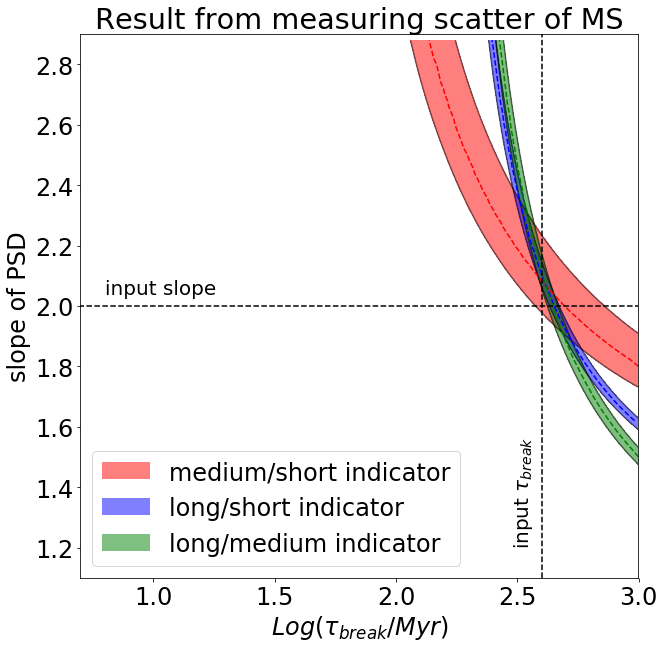

In [18]:
# Final plot
fig, ax = plt.subplots(figsize=(10, 10))
# plot contours - note that these are NOT the contours shown in Figure 7 in the manuscript 
# Contours in Figure 7 are denoting 1-sigma space derived from numerical simulations
CS = ax.contour(np.log10(tau_fine), slope_fine, Number_of_sigmas_deviation_reshaped_2_1,cmap=plt.cm.bone,levels=[1,500],alpha=0.5)
CS2 = ax.contour(np.log10(tau_fine), slope_fine, Number_of_sigmas_deviation_reshaped_3_1,cmap=plt.cm.bone,levels=[1,500],alpha=0.5)
CS3 = ax.contour(np.log10(tau_fine), slope_fine, Number_of_sigmas_deviation_reshaped_3_2,cmap=plt.cm.bone,levels=[1,500],alpha=0.5)
CS4 = ax.contourf(np.log10(tau_fine), slope_fine, Number_of_sigmas_deviation_reshaped_2_1, [0,1],colors=('r'),alpha=0.5)
CS5 = ax.contourf(np.log10(tau_fine), slope_fine, Number_of_sigmas_deviation_reshaped_3_1, [0,1],colors=('b'),alpha=0.5)
CS6 = ax.contourf(np.log10(tau_fine), slope_fine, Number_of_sigmas_deviation_reshaped_3_2, [0,1],colors=('g'),alpha=0.5)

# plot lines that are the best solution - this are the dashed lines shown as analytical solutions in Figure 7 of the manuscript!
plt.plot(np.log10(best_solution_2_1[:,1]),best_solution_2_1[:,0],'r',linestyle='dashed')
plt.plot(np.log10(best_solution_3_1[:,1]),best_solution_3_1[:,0],'b',linestyle='dashed')
plt.plot(np.log10(best_solution_3_2[:,1]),best_solution_3_2[:,0],'g',linestyle='dashed')

# plot what the input parameters are
plt.plot(np.ones(100)*2,'black',linestyle='dashed')
plt.axvline(x=np.log10(t_bend),color='black',linestyle='dashed')
plt.text(0.8, 2.04, 'input slope', fontsize=20,
               rotation=0, rotation_mode='anchor')
plt.text(2.55, 1.2, 'input $\\tau_{break}$', fontsize=20,
               rotation=90, rotation_mode='anchor')

# plot a legend
h1,_ = CS4.legend_elements()
h2,_ = CS5.legend_elements()
h3,_ = CS6.legend_elements()
ax.legend([h1[0], h2[0],h3[0]], ['medium/short indicator' , 'long/short indicator' ,'long/medium indicator' ])

ax.set_ylim(1.1,2.9)
ax.set_xlim(np.min(np.log10(tau_fine)),np.max(np.log10(tau_fine)))

ax.set_title('Result from measuring scatter of MS')
ax.set_xlabel('$Log(\\tau_{break}/Myr)$')
ax.set_ylabel('slope of PSD')

# commented out figure save
# plt.savefig('/Users/nevencaplar/Documents/Variability/MainSequence/Paper/Figures/' + 'slope_tau_degen.pdf', bbox_inches='tight')
plt.show()